In [1]:
# automatic run section 1 hec-ras project
# 03242021
import win32com.client, os, math
import numpy as np
from scipy import optimize as opt
import support
from datetime import datetime, timedelta
import shutil
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
hec_ras_folder = r"D:\East_river_flood_resilience\Greenbay\HEC-RAS\Hec_ras_control_test_0323"
# Path of the project
ras_file = hec_ras_folder + "//" + "wash_pp_0318.prj"
# Path of the plan text file
planfile = hec_ras_folder + "//" + "wash_pp_0318.p21"
# Path of the example plan text file
example_planfile = hec_ras_folder + "//" + "wash_pp_0318_example.p20"
# Path of flow text file
flowfile = hec_ras_folder + "//" + "wash_pp_0318.u05"
tempflowfile = hec_ras_folder + "//" + "wash_pp_0318_temp.u05"

In [3]:
# initiate the RAS control class
hec = win32com.client.Dispatch('RAS507.HECRASController')
# hec.Project_Open(ras_file)
# show main window?
hec.ShowRas()
hec.Project_Open(ras_file)

In [58]:
# build a pandas dataframe to store river information
# river_name 16 characters
# reach_name 16 characters
# node_name 8 characters
r = pd.DataFrame(columns = ['river_num','river_name','reach_num','reach_name',\
            'node_num','node_name','node_type'])
# get number of rivers, and river name
[nriv, riv_name] = hec.Geometry_GetRivers()
# print(nriv)
for i in range(nriv):
    # use riv_names to populate the structure
    # get the number of reaches and their names
    [a, nrch, rch_name] = hec.Geometry_GetReaches(i+1);
    for j in range(nrch):
        [a, b, nnode, node_names, node_type] = hec.Geometry_GetNodes\
          (i+1, j+1)
        for k in range(nnode):
                # assign node number, node name and node type
            # print(k)
            node_dict = dict({"river_num":i+1,"river_name":riv_name[i].rstrip(),\
            "reach_num":j+1,'reach_name':rch_name[j].rstrip(),'node_num':k+1,\
            "node_name":node_names[k].rstrip(),'node_type':node_type[k]})
            r = r.append(node_dict, ignore_index = True)

In [70]:
# read upstream boundary flow
zz_flow_path = r'D:\East_river_flood_resilience\Greenbay\HEC-RAS\Unsteady_flow\Unsteady_flow_data\resampled_discharge_oct10_dec30.csv'
zz_flow = pd.read_csv(zz_flow_path)
# add base flow
base_flow = 50
flow_max = zz_flow['Discharge(cfs)'].max() # maximum discharge
us_coord_num = zz_flow.shape[0] # number of points in time series data
flow_data = zz_flow['Discharge(cfs)'] + base_flow # flow time series data
# initial_flow = zz_flow['Discharge(cfs)']
flow_start_time = '20oct2020,0000'
# read downstream boundary stage
pp_stage_path = r'D:\East_river_flood_resilience\Greenbay\HEC-RAS\Unsteady_flow\Unsteady_flow_data\East_river_gauge_03102021\Clipped_0313_full_length\Hwy_PP_cliped.csv'
pp_stage = pd.read_csv(pp_stage_path, header = None )
ds_coord_num = pp_stage.shape[0] # number of points in stage hydrograph
stage_data = pp_stage[1]
stage_start_time = '21oct2020,0700'

In [71]:
# generate unsteady flow rile ""
flow_file_id = 'u08'
new_flow_file = hec_ras_folder + "//" + 'wash_pp_0318.' + flow_file_id
fid = open(new_flow_file, 'wt')
fid.write('Flow Title={0}\n'.format('Test_0324')) # title
fid.write('Program Version={0}\n'.format('5.07')) # program version
fid.write('Use Restart= {0}\n'.format('0')) # whether restart is used 0 is no, 1 is yes
# Intial flow
initial_flow = dict({'125285':50})
for xsnode in initial_flow:
    # xsnode.type
    river_name = r[r['node_name'] == xsnode]['river_name'].values[0]
    reach_name = r[r['node_name'] == xsnode]['reach_name'].values[0]
    # node_num = r[r['node_name'] == xsnode]['node_num'].values[0]
    fid.write('Initial Flow Loc={0:16s},{1:16s},{2:8s},{3}\n'.format(river_name,reach_name,xsnode, initial_flow[xsnode]))
# fid.close
# boundary condition
# upstream boundary condition
upstream_station = '125285'
river_name = r[r['node_name'] == upstream_station]['river_name'].values[0]
reach_name = r[r['node_name'] == upstream_station]['reach_name'].values[0]
fid.write('Boundary Location={0:16s},{1:16s},{2:8s},        ,                ,\n'.format(river_name,reach_name,upstream_station))
fid.write('Interval={0}\n'.format('15MIN'))
fid.write('Flow Hydrograph={0}\n'.format(us_coord_num))
# print flow data
count = 0
for i in flow_data:
    fid.write('%7.2f '%i)
    count = count + 1
    if count%10 == 0: # 10 data points each line
        fid.write('\n')
fid.write('\nFlow Hydrograph QMin={0:.2f}\n'.format(flow_max*0.05))    # 5% of peak flow as minimum flow
fid.write('DSS Path=\n')
fid.write('Use DSS=False\n')
fid.write('Use Fixed Start Time=True\n')
fid.write('Fixed Start Date/Time={0}\n'.format(flow_start_time)) # set flow data start time
fid.write('Is Critical Boundary=False\n')
fid.write('Critical Boundary Flow=\n')

# boundary condition
# downstream boundary condition
upstream_station = '80863'
river_name = r[r['node_name'] == upstream_station]['river_name'].values[0]
reach_name = r[r['node_name'] == upstream_station]['reach_name'].values[0]
fid.write('Boundary Location={0:16s},{1:16s},{2:8s},        ,                ,\n'.format(river_name,reach_name,upstream_station))
fid.write('Interval={0}\n'.format('5MIN')) # data intervals
fid.write('Stage Hydrograph={0}\n'.format(ds_coord_num))
# print flow data
count = 0
for i in stage_data:
    fid.write('%7.2f '%i) # total characters is 7 with 2 decimal
    count = count + 1
    if count%10 == 0: # 10 data points each line
        fid.write('\n')
# fid.write('\nFlow Hydrograph QMin={0}\n'.format(flow_max*0.05))    # 5% of peak flow as minimum flow
fid.write('\nDSS Path=\n')
fid.write('Use DSS=False\n')
fid.write('Use Fixed Start Time=True\n')
fid.write('Fixed Start Date/Time={0}\n'.format(stage_start_time)) # set flow data start time
fid.write('Is Critical Boundary=False\n')
fid.write('Critical Boundary Flow=\n')


24

In [72]:
# simulation sectting
# starting and ending of simulation
start_day = 22
start_month = 10
start_year = 2020
start_hour = 20
end_day = 2
end_month = 11
end_year = 2020
end_hour = 20
simulation_start = datetime(start_year,start_month,start_day,start_hour).strftime("%d%b%Y,%H%M")
simulation_end = datetime(end_year,end_month,end_day,end_hour).strftime("%d%b%Y,%H%M")
Computation_Interval = "1MIN"
Output_Interval = "1HOUR" # hydrograph output should be small
Instantaneous_Interval = '1HOUR' # detailed output
Mapping_Interval = "12HOUR"
Theta = 1

In [73]:
# rewrite plan file
# run the model
# open plan file
fid_used = open(planfile, 'wt') # write
fid_example = open(example_planfile, 'r') # read
for tline in fid_example: # read each line in example plan file
    tline = tline.rstrip()
    print(tline)
    # find "Simulation Date" line
    if "Simulation Date" in tline:
        print('Simulation Date Found')
        fid_used.write("Simulation Date={0},{1}\n".format(simulation_start, simulation_end))
    elif "Geom File" in tline:
        print('Geom File Found')
        geom_file_id = tline
        fid_used.write("%s\n"%tline)
    elif "Flow File" in tline:
        print('Flow File Found')
        fid_used.write('Flow File={0}\n'.format(flow_file_id))
    elif "Computation Interval" in tline:
        print('Computation Interval Found')
        fid_used.write("Computation Interval={0}\n".format(Computation_Interval))
    elif "Output Interval" in tline:
        print('Output Interval Found')
        fid_used.write('Output Interval={0}\n'.format(Output_Interval))
    elif "Instantaneous Interval" in tline:
        print('Instantaneous Interval Found')
        fid_used.write("Instantaneous Interval={0}\n".format(Instantaneous_Interval))
    elif "Mapping Interval" in tline:
        print('Mapping Interval Found')
        fid_used.write("Mapping Interval={0}\n".format(Mapping_Interval))
    else:
        fid_used.write("%s\n"%tline)

Plan Title=Plan 21
Program Version=5.07
Short Identifier=Plan 21
Simulation Date=22Oct2020,2000,02Nov2020,2000
Simulation Date Found
Geom File=g06
Geom File Found
Flow File=u05
Flow File Found
Subcritical Flow
K Sum by GR= 0
Std Step Tol= 0.01
Critical Tol= 0.01
Num of Std Step Trials= 20
Max Error Tol= 0.3
Flow Tol Ratio= 0.001
Split Flow NTrial= 30
Split Flow Tol= 0.02
Split Flow Ratio= 0.02
Log Output Level= 0
Friction Slope Method= 1
Unsteady Friction Slope Method= 2
Unsteady Bridges Friction Slope Method= 1
Parabolic Critical Depth
Global Vel Dist= 0 , 0 , 0
Global Log Level= 0
CheckData=True
Encroach Param=-1 ,0,0, 0
Computation Interval=5MIN
Computation Interval Found
Output Interval=12HOUR
Output Interval Found
Instantaneous Interval=12HOUR
Instantaneous Interval Found
Mapping Interval=12HOUR
Mapping Interval Found
Computation Time Step Use Courant=        0
Computation Time Step Use Time Series=    0
Computation Time Step Max Courant=
Computation Time Step Min Courant=
Computa

In [74]:

# show computation window?
hec.Compute_ShowComputationWindow()
print('HEC-RAS started')
print('Simulation from {0} to {1}'.format(simulation_start, simulation_end))
print(geom_file_id)
print('Flow file id={0}'.format(flow_file_id))
print('Computation interva={0}, output_interval={1}'.format(Computation_Interval,Instantaneous_Interval))
# compute current plan
NMsg, TabMsg, block = None, None, True
hec.Compute_CurrentPlan(NMsg, TabMsg, block)
run_stat = hec.Compute_Complete
# wait for hec-ras to complete the computation
while run_stat == False:
    run_stat = hec.Compute_Complete
bool_run = run_stat
print('HEC-RAS completed')

HEC-RAS started
Simulation from 22Oct2020,2000 to 02Nov2020,2000
Geom File=g06
Flow file id=u08
Computation interva=1MIN, output_interval=1HOUR
HEC-RAS completed


In [75]:
# retrieve the stage and flow for each time profile at corss-section
# and store it 
[nprof, prof] = hec.Output_GetProfiles()
# get number of profiles, and profiles (max WS, t1, t2, ..., tn)
# 'Max WS',
# '22OCT2020 2000',
#  '23OCT2020 0000',
observe_station = '104916'
river_num = r[r['node_name'] == observe_station]['river_num'].values[0]
reach_num = r[r['node_name'] == observe_station]['reach_num'].values[0]
node_num = r[r['node_name'] == observe_station]['node_num'].values[0]
simu_obs_elev = np.empty([nprof-1], dtype = 'float') # nprof-1 remove the first row (maximum ws)
simu_obs_flow = np.empty([nprof-1], dtype = 'float')
j = 0
for i in range(len(prof)):
    if i+1 == 1:
        continue
    else:
        # hec.Output_NodeOutput(river_num, reach_num, node_num, 2, timestep, 2: WSE)
        simu_obs_elev[j] = hec.Output_NodeOutput(river_num,reach_num,node_num,2,i+1,2)[0] # i+1=1: skip the maximum ws
        simu_obs_flow[j] = hec.Output_NodeOutput(river_num,reach_num,node_num,2,i+1,9)[0]
        # print(i+1)
        j = j + 1

In [77]:
# simulated dataframe
simu_storage = pd.DataFrame(columns = ['Date_min','Date','Simu_stage','Simu_flow'])
simu_storage['Date'] = prof[1:]
simu_storage['Simu_stage'] = simu_obs_elev
simu_storage['Simu_flow'] = simu_obs_flow
# transfrom date into minute timestamp
minute_stamp = np.zeros((len(simu_obs_elev)))
for i in range(len(simu_obs_elev)):
    timestamp = datetime.strptime(simu_storage['Date'][i], "%d%b%Y %H%M")
    reference_point = datetime(2020,10,20) # reference timestamp
    timesince = timestamp - reference_point
    minutessince = int(timesince.total_seconds()/60) # calculate the minute
    minute_stamp[i] = minutessince
simu_storage['Date_min'] = minute_stamp # date_min is the minutes since the reference point

In [78]:
# read observation data
obs_location = r"D:\East_river_flood_resilience\Greenbay\HEC-RAS\Unsteady_flow\Unsteady_flow_data\East_river_gauge_03102021\Clipped_0313_full_length\Midway_Rd_cliped.csv"
obs_stage = pd.read_csv(obs_location, header = None)
obs_stage.columns = ['Date', 'Obs_stage']
# transfrom date into minute timestamp
minute_stamp = np.zeros((obs_stage.shape[0]))
for i in range(obs_stage.shape[0]):
    timestamp = datetime.strptime(obs_stage['Date'][i], '%m/%d/%y %I:%M:%S %p')
    reference_point = datetime(2020,10,20) # reference timestamp
    timesince = timestamp - reference_point
    minutessince = int(timesince.total_seconds()/60) # calculate the minute
    minute_stamp[i] = minutessince
obs_stage['Date_min'] = minute_stamp # date_min is the minutes since the reference point

In [79]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [80]:
# intersect two data frame
merged_stage = pd.merge(simu_storage[['Date_min','Simu_stage']],obs_stage[['Date_min','Obs_stage']],\
         how='left', on = ['Date_min'])
# calculate the rmse between simulation and observation
mean_squared_error(merged_stage['Obs_stage'],merged_stage['Simu_stage'])

2.0938867335091343e+76

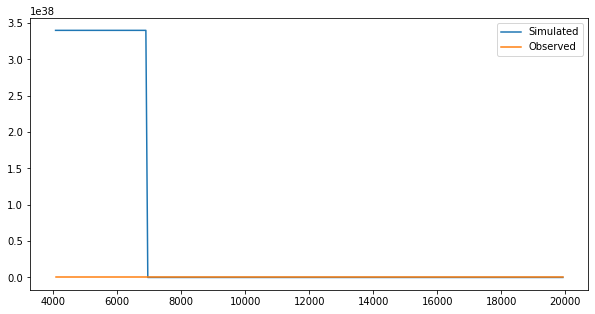

In [81]:
# plot the simulation and observed stages
fig, ax = plt.subplots(figsize = (10,5))
ax.plot(merged_stage['Date_min'],merged_stage['Simu_stage'],label = 'Simulated')
ax.plot(merged_stage['Date_min'],merged_stage['Obs_stage'], label = 'Observed')
ax.legend()

In [16]:
# quit hec-ras
hec.QuitRas()
del hec

In [16]:
# optimize mannings for this section
from scipy import optimize as opt

In [17]:
def ObjFun(x):
    global hec, nRS, observe_station, r, obs_stage
    # get the river and reach names
    river_name = r[r['node_name'] == observe_station]['river_name'].values[0]
    reach_name = r[r['node_name'] == observe_station]['reach_name'].values[0]
    nRS = r.shape[0] # number of cross-sections
    # assign mannings
    nLOB, nCh, nROB = x[0], x[1], x[2]
    for i in range(0, nRS):
        for i in range(0,nRS):
            ErrMsg = None # list of error message
            v0,v1,v2,v3,v4,v5,v0,ErrMsg = hec.Geometry_SetMann_LChR(r['river_name'][0],\
        r['reach_name'][0],r['node_name'][i],nLOB,nCh,nROB,ErrMsg) # asssign manning
    print('HEC-RAS started')
    # compute current plan
    NMsg, TabMsg, block = None, None, True
    hec.Compute_CurrentPlan(NMsg, TabMsg, block)
    run_stat = hec.Compute_Complete
    # wait for hec-ras to complete the computation
    while run_stat == False:
        run_stat = hec.Compute_Complete
    bool_run = run_stat
    print('HEC-RAS completed')
    # retrieve the stage and flow for each time profile at corss-section
    # and store it 
    [nprof, prof] = hec.Output_GetProfiles()
    # get number of profiles, and profiles (max WS, t1, t2, ..., tn)
    # 'Max WS',
    # '22OCT2020 2000',
    #  '23OCT2020 0000',
    river_num = r[r['node_name'] == observe_station]['river_num'].values[0]
    reach_num = r[r['node_name'] == observe_station]['reach_num'].values[0]
    node_num = r[r['node_name'] == observe_station]['node_num'].values[0]
    simu_obs_elev = np.empty([nprof-1], dtype = 'float') # nprof-1 remove the first row (maximum ws)
    simu_obs_flow = np.empty([nprof-1], dtype = 'float')
    j = 0
    for i in range(len(prof)):
        if i+1 == 1:
            continue
        else:
            # hec.Output_NodeOutput(river_num, reach_num, node_num, 2, timestep, 2: WSE)
            simu_obs_elev[j] = hec.Output_NodeOutput(river_num,reach_num,node_num,2,i+1,2)[0] # i+1=1: skip the maximum ws
            # simu_obs_flow[j] = hec.Output_NodeOutput(river_num,reach_num,node_num,2,i+1,9)[0]
            # print(i+1)
            j = j + 1
    # simulated dataframe
    simu_storage = pd.DataFrame(columns = ['Date_min','Date','Simu_stage'])
    simu_storage['Date'] = prof[1:]
    simu_storage['Simu_stage'] = simu_obs_elev
    # simu_storage['Simu_flow'] = simu_obs_flow
    # transfrom date into minute timestamp
    minute_stamp = np.zeros((len(simu_obs_elev)))
    for i in range(len(simu_obs_elev)):
        timestamp = datetime.strptime(simu_storage['Date'][i], "%d%b%Y %H%M")
        reference_point = datetime(2020,10,20) # reference timestamp
        timesince = timestamp - reference_point
        minutessince = int(timesince.total_seconds()/60) # calculate the minute
        minute_stamp[i] = minutessince
    simu_storage['Date_min'] = minute_stamp # date_min is the minutes since the reference point
    # intersect two data frame
    merged_stage = pd.merge(simu_storage[['Date_min','Simu_stage']],obs_stage[['Date_min','Obs_stage']],\
             how='left', on = ['Date_min'])
    # calculate the rmse between simulation and observation
    rmse = sqrt(mean_squared_error(merged_stage['Obs_stage'],merged_stage['Simu_stage']))
    print(rmse)
    print(x)
    return rmse

In [18]:
def iter_control(xk): # call back function
    print('nLOB=%15.6f, nCh=%15.6f, nROB=%15.6f, ' %\
    (xk[0],xk[1],xk[2]))
    print('funk=%15.6f' % (ObjFun(xk)))
    return 0

In [19]:
print("\nIteration process: Nealder-Mead simplex")
x0 = np.array([0.05,0.04,0.05])                # initial solution
bound = opt.Bounds([0.03, 0.02, 0.03], [0.12,0.07,0.12])
Xopt = opt.minimize(ObjFun,x0,callback=iter_control,method='Nelder-Mead')   # optimization


Iteration process: Nealder-Mead simplex
HEC-RAS started
HEC-RAS completed
6.413119761509894
[0.05 0.04 0.05]
HEC-RAS started
HEC-RAS completed
2.5992450350717196
[0.0525 0.04   0.05  ]
HEC-RAS started
HEC-RAS completed
622.1241286594236
[0.05  0.042 0.05 ]
HEC-RAS started
HEC-RAS completed
2.599403343048806
[0.05   0.04   0.0525]
HEC-RAS started
HEC-RAS completed
2.647297473954184
[0.05166667 0.038      0.05166667]
nLOB=       0.052500, nCh=       0.040000, nROB=       0.050000, 
HEC-RAS started
HEC-RAS completed
2.5992450350717196
[0.0525 0.04   0.05  ]
funk=       2.599245
HEC-RAS started
HEC-RAS completed
2.632760964863378
[0.05277778 0.03866667 0.05277778]
nLOB=       0.052500, nCh=       0.040000, nROB=       0.050000, 
HEC-RAS started
HEC-RAS completed
2.5992450350717196
[0.0525 0.04   0.05  ]
funk=       2.599245
HEC-RAS started
HEC-RAS completed
2.572911933289182
[0.05185185 0.04111111 0.05185185]
HEC-RAS started
HEC-RAS completed
2.5372126026594994
[0.05194444 0.04266667 0.05

KeyboardInterrupt: 